# Binary Image Classification

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2019-10-20 11:35:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.222.208, 2800:3f0:4005:402::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.222.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142,65M  1,69MB/s    in 91s     

2019-10-20 11:37:09 (1,57 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [13]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2019-10-20 12:10:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.30.208, 2800:3f0:4005:401::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.30.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/validation-horse-or-human.zip’

/tmp/validation-hor 100%[===================>]  10,95M  2,36MB/s    in 4,7s    

2019-10-20 12:10:46 (2,33 MB/s) - ‘/tmp/validation-horse-or-human.zip’ saved [11480187/11480187]



In [1]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [14]:
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [15]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

In [16]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))
print('total validation horse images:', len(os.listdir(validation_horse_dir)))
print('total validation human images:', len(os.listdir(validation_human_dir)))

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

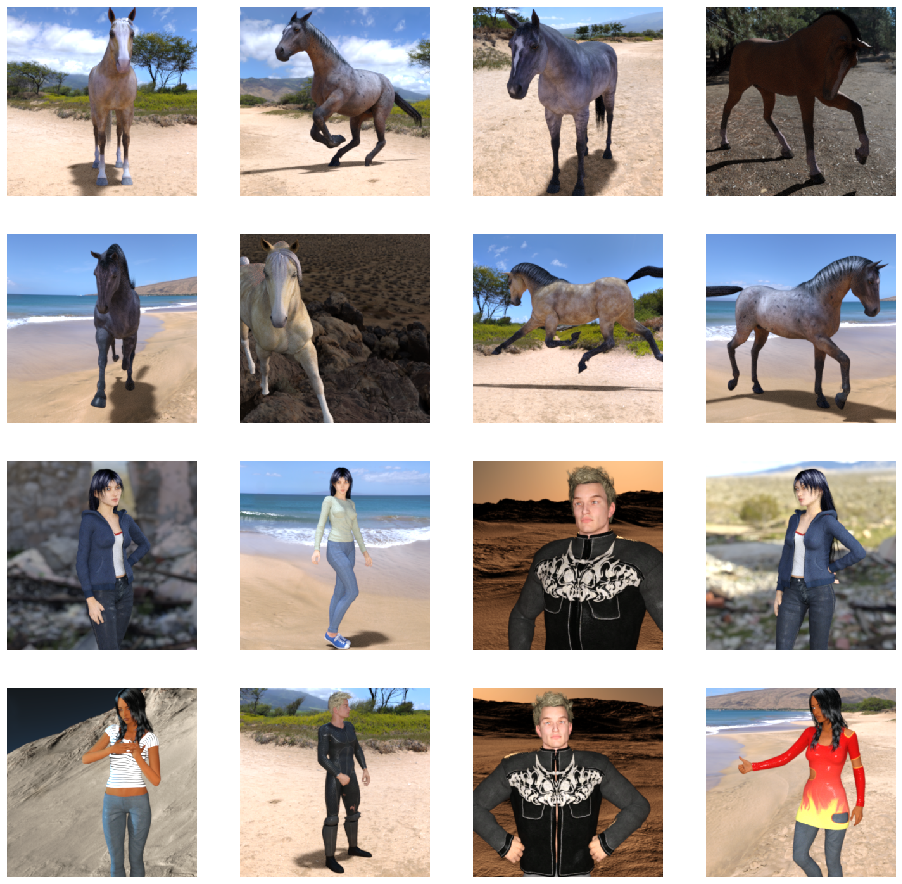

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building the model

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.001),
              metrics=['acc']
             )


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    '/tmp/horse-or-human/',
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    '/tmp/validation-horse-or-human',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [20]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs=15,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=8
)

Epoch 1/15
8/8 [==============================] - 42s 5s/step - loss: 0.0066 - acc: 0.9978 - val_loss: 1.6315 - val_acc: 0.8398
Epoch 2/15
8/8 [==============================] - 40s 5s/step - loss: 0.0032 - acc: 1.0000 - val_loss: 2.2760 - val_acc: 0.8125
Epoch 3/15
8/8 [==============================] - 43s 5s/step - loss: 7.1955e-04 - acc: 1.0000 - val_loss: 2.3273 - val_acc: 0.8164
Epoch 4/15
8/8 [==============================] - 39s 5s/step - loss: 0.0398 - acc: 0.9922 - val_loss: 2.3841 - val_acc: 0.7344
Epoch 5/15
8/8 [==============================] - 39s 5s/step - loss: 0.2890 - acc: 0.9032 - val_loss: 1.6837 - val_acc: 0.8359
Epoch 6/15
8/8 [==============================] - 39s 5s/step - loss: 0.0077 - acc: 0.9967 - val_loss: 1.6327 - val_acc: 0.8516
Epoch 7/15
8/8 [==============================] - 40s 5s/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.7315 - val_acc: 0.8477
Epoch 8/15
8/8 [==============================] - 39s 5s/step - loss: 4.9020e-04 - acc: 1.0000 - val